## Topic Modeling
**Topic modeling :** is a technique in natural language processing that aims to discover hidden themes or topics within a collection of text.

In this notebook, we leverage **BERT**, a powerful pre-trained language model, to extract contextualized word embeddings for improved topic modeling accuracy and granularity.

Here's a step-by-step guide on how you can perform topic modeling using a pre-trained BERT:

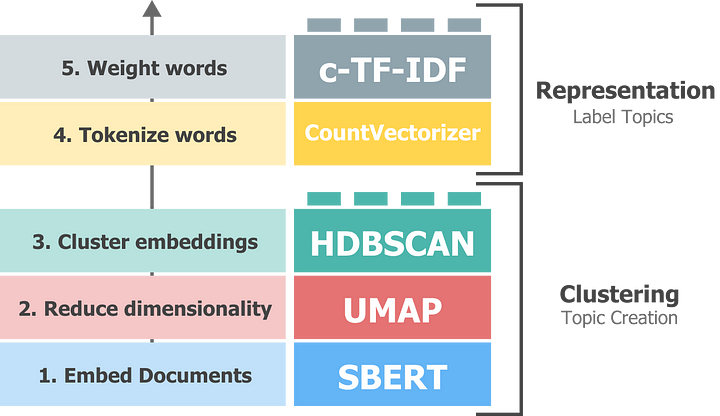

- Create embeddings using "sentence-transformers/LaBSE" model
- Dimensionality reduction using UMAP((Uniform Manifold Approximation and Projection)
- Clustring using HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)
- Scikit-learn's CountVectorizer is used to transform a corpora of text to a vector of term / token counts.
- Topic Representer using bertopic library provides topic modeling functionality based on BERT embeddings

### Objectives
- Understand the basics of topic modeling.
- Learn how to leverage BERT embeddings for more context-aware representations.
- Implement a topic modeling pipeline using a pre-trained BERT model.
- Visualize and interpret the discovered topics in a given text corpus.


## Exploring Data
---


In [1]:
%%capture
!pip install bertopic==0.16.0 datasets==2.16.1 Arabic-Stopwords==0.4.3

In [2]:
from datasets import load_dataset
import pandas as pd
import re
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# load datasets from Huggingface
from datasets import load_dataset
ar_dataset = load_dataset("saudinewsnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/31030 [00:00<?, ? examples/s]

In [4]:
ar_dataset

DatasetDict({
    train: Dataset({
        features: ['source', 'url', 'date_extracted', 'title', 'author', 'content'],
        num_rows: 31030
    })
})

In [5]:
ar_dataset['train'][0]

{'source': 'aawsat',
 'url': 'http://aawsat.com/home/article/410826/بريطانيا-أربعة-محاور-لاستراتيجية-جديدة-تتصدى-للتطرف-على-مدى-خمس-سنوات',
 'date_extracted': '2015-07-21 02:51:32',
 'title': 'بريطانيا: أربعة محاور لاستراتيجية جديدة تتصدى للتطرف على مدى خمس سنوات',
 'author': 'لندن: رنيم حنوش',
 'content': 'حدد رئيس الوزراء البريطاني ديفيد كاميرون، اليوم (الاثنين)، ملامح استراتيجية للتصدي للتطرف داخل بريطانيا؛ وهي مسألة اعتبرها كاميرون "صراع جيلنا"، متعهدا خلال خطابه في مدينة بيرمنغهام بالتصدي لهؤلاء الذين ينشرون التطرف بين الشبان المسلمين البريطانيين.\n\n ورسم كاميرون الاطار العام لاستراتيجية مكافحة التطرف التي المقرر ان تنشر كاملة في وقت لاحق هذا العام، والتي تسعى للتصدي لانتشار الأفكار المتطرفة التي يروج لها متشددو تنظيم "داعش".\n\n وحسبما تناقلت وسائل الإعلام البريطانية، فإن خطة رئيس الوزراء ستكون على مدى خمسة أعوام للقضاء على التطرف الداخلي من خلال أربعة محاور، وهي: القضاء على إيديولوجية التطرف، والوقوف في وجه عمليات التجنيد وغسل الأدمغة بالأفكار المتطرفة، وإعادة اصوات الاسلام الم

In [6]:
ar_raw_dataset= [
    {
        'content': record['content'],
        'source': record['source'],
        'date': record['date_extracted']
    }
    for record in ar_dataset['train']
]

In [7]:
import pandas as pd
raw_dataset_df = pd.DataFrame( ar_raw_dataset )
raw_dataset_df.head()

,content,source,date
0,حدد رئيس الوزراء البريطاني ديفيد كاميرون، اليو...,aawsat,2015-07-21 02:51:32
1,أصدر الرئيس عبدربه منصور هادي رئيس الجمهورية ا...,aawsat,2015-07-21 02:51:33
2,وافق مجلس الأمن الدولي، اليوم (الاثنين)، على ا...,aawsat,2015-07-21 02:51:35
3,قال مسؤولون أفغان ان 14 جنديا أفغانيا قتلوا في...,aawsat,2015-07-21 02:51:37
4,أعلنت وزارة الخارجية الايطالية، اليوم (الاثنين...,aawsat,2015-07-21 02:51:38


In [8]:
# Suffling data
raw_dataset_df = raw_dataset_df.sample(frac=1, random_state=101)
raw_dataset_df.head()

,content,source,date
26442,عين اليوم – الدمام\n عقدت أمانة المنطقة الشرق...,3alyoum,2015-08-09 20:45:39
24574,"""لم نر الإرهاب إلا بعد تسييس الدين، ليصير الو...",alwatan,2015-08-07 06:32:39
20441,رغد عشميل – عين اليوم\n عزز فريق ريال مدريد ا...,3alyoum,2015-08-06 19:16:04
7927,أوضحت إدارة مستشفى الدوادمي العام في بيان ...,alriyadh,2015-07-24 16:23:27
14012,الشعر الجميل يبقى محفوراً في الذاكرة لا يم...,alriyadh,2015-07-31 03:53:17



## cleaning Data
---


In [9]:
def clean_text(text: str):
    if not isinstance(text, str):
        # raise TypeError("text must be a string")
        return ""

    # remove urls
    text = re.sub(r"http\S+", " رابط ", text)

    # replace any digit with رقم
    text = re.sub(r"\d+", " رقم ", text)

    # set space before and after any punctuation
    text = re.sub(r"([^\w\s])", r" \1 ", text)

    # remove extra spaces
    text = re.sub(r"\s+", " ", text)

    #remove dollar sign $
    text = re.sub(r"\$", "" , text)

    words = word_tokenize(text)
    text = " ".join([ w for w in words if len(w) > 1 ] )

    #convert all text to lowercase
    return text.lower().strip()


In [10]:
raw_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31030 entries, 26442 to 13151
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  31030 non-null  object
 1   source   31030 non-null  object
 2   date     31030 non-null  object
dtypes: object(3)
memory usage: 969.7+ KB


In [11]:
raw_dataset_df['content'] = raw_dataset_df['content'].apply(clean_text)

In [12]:
raw_dataset_df['text_len'] = raw_dataset_df['content'].apply(len)

In [13]:
raw_dataset_df.head(2)

,content,source,date,text_len
26442,عين اليوم الدمام عقدت أمانة المنطقة الشرقية ال...,3alyoum,2015-08-09 20:45:39,1094
24574,`` لم نر الإرهاب إلا بعد تسييس الدين ليصير الو...,alwatan,2015-08-07 06:32:39,3378


Text(0, 0.5, 'Count')

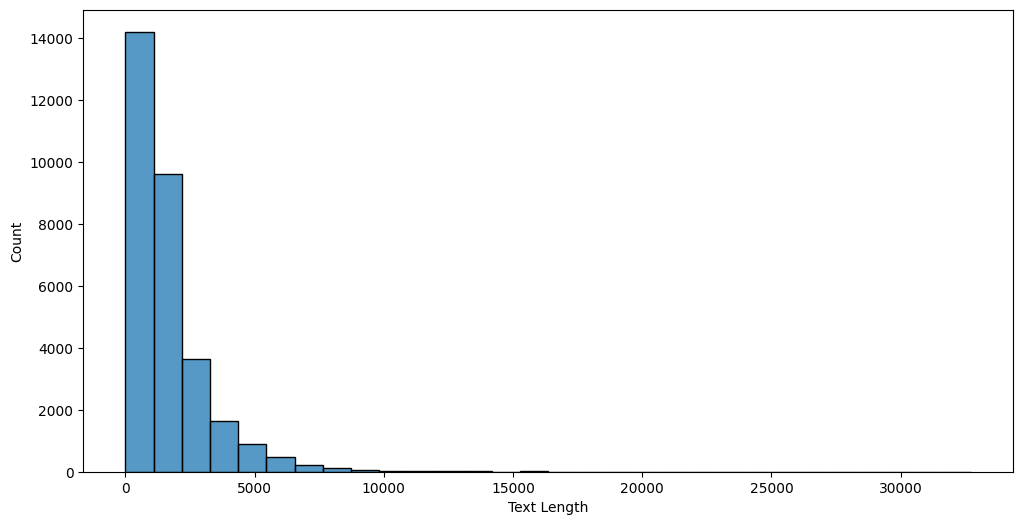

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(raw_dataset_df['text_len'], bins=30)
plt.xlabel('Text Length')
plt.ylabel('Count')

In [15]:
# Filter out rows where the length of the text is greater than a certain threshold = 10k
print(f'Original Data, Num of rows: {raw_dataset_df.shape}')
threshold = 10000
raw_dataset_df = raw_dataset_df[ raw_dataset_df['text_len'] <= threshold ]
print(f'Filtered Data, Num of rows: {raw_dataset_df.shape}')

Original Data, Num of rows: (31030, 4)
Filtered Data, Num of rows: (30902, 4)


In [16]:
# Remove Duplicates
print(f'Original Data, Num of rows: {raw_dataset_df.shape}')
raw_dataset_df.drop_duplicates(['content'], inplace=True)
print(f'Without Duplicates, Num of rows: {raw_dataset_df.shape}')

Original Data, Num of rows: (30902, 4)
Without Duplicates, Num of rows: (29691, 4)


In [17]:
# Convert Date_Extracted to datetime format
raw_dataset_df['datetime_stamp'] = raw_dataset_df['date'].apply(lambda v: datetime.strptime(v, "%Y-%m-%d %H:%M:%S"))
raw_dataset_df['datetime_stamp'].head(2)

26442   2015-08-09 20:45:39
24574   2015-08-07 06:32:39
Name: datetime_stamp, dtype: datetime64[ns]

In [18]:
# Set the time part (hour, minute, second) to zero for each datetime value.
# Because each second or minute represents a different time, we only need to consider the day

raw_dataset_df['datetime_stamp'] = raw_dataset_df['datetime_stamp'].apply(lambda v: v.replace(hour=0, minute=0, second=0))
raw_dataset_df['datetime_stamp'].head(2)

26442   2015-08-09
24574   2015-08-07
Name: datetime_stamp, dtype: datetime64[ns]

## Embedding

---

In [19]:
from sentence_transformers import SentenceTransformer

model_id = "sentence-transformers/LaBSE"
# model_id= "distiluse-base-multilingual-cased-v2" >> defualt model
embedding_model = SentenceTransformer(model_id, device="cuda:0")

# you can use another model, but LaBSE(Language-agnostic BERT Sentence Embeddings) is used for creating embeddings (Multi-Languages)

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [20]:
#Creat Embeddings
batch_size= 2
news_embeddings = embedding_model.encode(raw_dataset_df['content'].values, batch_size = batch_size, show_progress_bar=True)

Batches:   0%|          | 0/14846 [00:00<?, ?it/s]

In [21]:
news_embeddings.shape

# LaBSE >> 768
# distiluse-base-multilingual-cased-v2 >> 512

(29691, 768)

## Dimension Reduction

---
Using UMAP

In [51]:
from umap import UMAP

umap_model = UMAP(n_neighbors=15, n_components=15,
                  min_dist=0.0, metric='cosine',
                  random_state=101)


# from sklearn.decomposition import PCA

#  dim_model = PCA(n_neighbors=15, n_components=15,
#                   min_dist=0.0, metric='cosine',
#                   random_state=101)
# topic_model = BERTopic(umap_model=dim_model)

## Clustering
---
Using HDBSCAN

In [50]:
from hdbscan import HDBSCAN

# A higher min_cluster_size will generate fewer topics
# A lower min_cluster_size will generate more topics.

hdbscan_model = HDBSCAN(min_cluster_size=50, # reduce it to get more and smaller clusters
                        metric='euclidean', ## try cosine
                        cluster_selection_method='eom',
                        prediction_data=True)


# from sklearn.cluster import KMeans
# cluster_model = KMeans(min_cluster_size=30,
#                         metric='cosine',
#                         cluster_selection_method='eom',
#                         prediction_data=True)
# topic_model = BERTopic(hdbscan_model=cluster_model)

## Vectorizer

---
Using CountVectorizer

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import arabicstopwords.arabicstopwords as stp

stop_words = stp.stopwords_list()

vectorizer_model = CountVectorizer(min_df= 5, # Words that occur in fewer than 5 documents will be ignored.
                                   stop_words=stop_words,
                                   analyzer='word',
                                   lowercase=True, # This parameter indicates whether to convert all text to lowercase before tokenization.
                                   max_df=0.3, # Words that occur in more than 30% of the documents will be ignored.
                                   ngram_range=(1, 3)
                                   )


## Topic Representer

---

In [25]:
from bertopic.representation import KeyBERTInspired

keybert_model = KeyBERTInspired()

representation_model = {
    "KeyBERT": keybert_model
}

## Let's Go

---

In [26]:
from bertopic import BERTopic

topic_model = BERTopic(
    # Pipeline models
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,

    # Hyperparameters
    top_n_words=10,
    verbose=True
)

topics, probs =  topic_model.fit_transform(
    raw_dataset_df['content'].values,
    news_embeddings
)

2024-02-11 13:07:59,990 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-11 13:09:04,864 - BERTopic - Dimensionality - Completed ✓
2024-02-11 13:09:04,868 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-11 13:09:11,550 - BERTopic - Cluster - Completed ✓
2024-02-11 13:09:11,570 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-11 13:10:22,597 - BERTopic - Representation - Completed ✓


In [27]:
print(
    raw_dataset_df['content'].values[50],'\n',
    topics[50],'\n', probs[50]
)

بعد مرور رقم سنوات على تشييد جدار الفصل العنصري في القدس تحولت الأحياء الفلسطينية في القدس إلى منطقة عشوائية وعزل ثلث السكان الفلسطينيين المقدر عددهم بـ رقم ألفا عن مركز حياتهم في القدس وباتوا يعانون من حياة قوامها الإهمال المخزي وشي الجدار في القدس بعد أن التزمت الحكومة الإسرائيلية أمام المحكمة الإسرائيلية العليا وأصدرت قرارات حكومية تعهدت باستمرار سير الحياة السوي لدى سكان الأحياء المقدسي الذين ظل وا وراء الجدار إلى جانب الحفاظ على نسيج الحياة المشترك لمجمل السكان الفلسطينيين عبر جهتي الجدار ولفتت جمعية حقوق المواطن في إسرائيل في أحدث تقرير لها أمس إلى أن من بين هذه القرارات القرار رقم الذي اتخذ في رقم الذي فرض مسؤولية تحضير الجاهزية الخاصة على بلدية القدس والوزارات الإسرائيلية المختلفة مشددا على أن تشييد الجدار لا يعني المس بحقوق سكان الأحياء الذين يعيشون في المنطقة التي احتلتها إسرائيل عام رقم ويحملون بطاقات هوي إسرائيلية مستندا على الإدراك بأن من واجب إسرائيل منذ لحظة فرض سيادتها على أحياء القدس الشرقي بعد احتلالها الحفاظ أيضا على مجمل الحقوق المكفولة لكل ساكن وفق للقانونيين الإسر

In [28]:
topic_model.get_topic(17)

[('سوق العمل', 0.012090110184316348),
 ('وزارة التعليم', 0.010666570127732668),
 ('التعليم العام', 0.008558569589928107),
 ('التعليم العالي', 0.007731554183288119),
 ('الطالب', 0.007673034701951381),
 ('الموظف', 0.007555302669944982),
 ('الدراسي', 0.00664639670429232),
 ('التوظيف', 0.006564701735276082),
 ('الابتعاث', 0.006168687289803269),
 ('المعلمين', 0.006164608591577683)]

In [29]:
raw_dataset_df['topic'] = topics
raw_dataset_df['prob'] = probs

In [30]:
raw_dataset_df[ raw_dataset_df['topic'] == 17 ].head(5)

,content,source,date,text_len,datetime_stamp,topic,prob
4815,التقارير المنشورة مؤخرا عن زيادة ساعات العمل ف...,okaz,2015-07-22 10:05:19,900,2015-07-22,17,0.761476
9410,أكدت وزارة الاقتصاد والتخطيط أن الإناث السعودي...,alriyadh,2015-07-25 23:35:20,1316,2015-07-25,17,0.642657
10403,نفذت منظمة التعاون الاقتصادي والتنمية oecd درا...,aljazirah,2015-07-26 16:49:32,1477,2015-07-26,17,1.000000
10917,من تجارب القائمين على الجمعيات نجد أننا في حاج...,alwatan,2015-07-26 16:58:31,1465,2015-07-26,17,0.562898
17995,في كل مرة يعتقد مجتمعنا أنه تعافى وتم طي صفحة ...,aljazirah,2015-08-03 21:08:06,2328,2015-08-03,17,1.000000


In [31]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Representative_Docs
0,-1,9608,-1_سوق عكاظ_مليار ريال_رقم مليار ريال_الهيئة ا...,"[سوق عكاظ, مليار ريال, رقم مليار ريال, الهيئة ...","[سلمان عبدالعزيز آل, عبدالعزيز آل سعود, سعود ح...",[واس الرياض رأس نائب خادم الحرمين الشريفين صاح...
1,0,4099,0_الموسم_اللاعب_اللاعبين_لكرة,"[الموسم, اللاعب, اللاعبين, لكرة, لكرة القدم, ا...","[الموسم الماضي, اللاعبين, لاعبي, اللاعب, اللاع...",[تتجه إدارة النادي الأهلي لطلب البطاقات الدولي...
2,1,1071,1_الإيراني_الاتفاق النووي_وزير الخارجية_كيري,"[الإيراني, الاتفاق النووي, وزير الخارجية, كيري...","[الاتفاق النووي الإيراني, الاتفاق النووي إيران...",[تشهد العاصمة القطرية اليوم مباحثات متعددة الأ...
3,2,936,2_عدن_المقاومة_الحوثيين_الحوثي,"[عدن, المقاومة, الحوثيين, الحوثي, المقاومة الش...","[ميليشيات الحوثي, عدن, الميليشيات الحوثية, الم...",[استهدف طيران التحالف بغارات عنيفة مواقع ميليش...
4,3,533,3_وإنشاء_النقل العام_رقم مليون ريال_جسر,"[وإنشاء, النقل العام, رقم مليون ريال, جسر, الن...","[المشروع رقم, تنفيذ مشروع, ومشروع, البلدية وال...",[اعتمد معالي وزير الشئون البلدية والقروية المه...
...,...,...,...,...,...,...
87,86,58,86_المسافرين_الطيران المدني_هيئة الطيران_هيئة ...,"[المسافرين, الطيران المدني, هيئة الطيران, هيئة...","[مطار الملك خالد, بمطار الملك خالد, خالد الدول...",[لم يكن غريبا أن يتكدس المسافرون في أحد أكبر م...
88,87,56,87_الجمارك_جمرك_تهريب_رجال الجمارك,"[الجمارك, جمرك, تهريب, رجال الجمارك, مخبأة, ال...","[تهريب, لتهريب, رجال الجمارك, التهريب, الجمارك...",[أحبط رجال الجمارك بمطار الملك عبدالعزيز الدول...
89,88,55,88_حرس_حرس الحدود_البحث والإنقاذ_والإنقاذ,"[حرس, حرس الحدود, البحث والإنقاذ, والإنقاذ, ال...","[البحث والإنقاذ, والإنقاذ, والسباحة, صحية جيدة...",[باشرت فرق البحث والإنقاذ في قطاعات حرس الحدود...
90,89,53,89_الحجاج_حجاج_وزارة الحج_لحجاج,"[الحجاج, حجاج, وزارة الحج, لحجاج, للحج, للحجاج...","[حجاج, حجار, الحجاج, حج, موسم حج, موسم حج العا...",[وزير الحج تستعد وزارة الحج لإطلاق برنامج التس...


## Visualization

---

In [32]:
topic_model.visualize_topics()

In [33]:
topic_model.visualize_heatmap()

In [34]:
# Display each topics per source
topics_per_class = topic_model.topics_per_class(
    raw_dataset_df['content'].values,
    classes=raw_dataset_df['source'].values,
)

14it [00:21,  1.53s/it]


In [52]:
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=15)

In [36]:
# Display each topics per Date
topics_over_time = topic_model.topics_over_time(
    raw_dataset_df['content'].values,
    raw_dataset_df['datetime_stamp'].values
)

18it [01:10,  3.90s/it]


In [53]:
topic_model.visualize_topics_over_time(
    topics_over_time,
    topics=[10, 11, 22, 13, 7, 15, 5, 17, 2, 20] # try other topics
)

In [38]:
hierarchical_topics = topic_model.hierarchical_topics(
    raw_dataset_df['content'].values
)

100%|██████████| 90/90 [00:00<00:00, 103.82it/s]


In [39]:
topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics
)

## Topics Merging

---

In [54]:
# topics_to_merge = [
#     [15, 60, 4],
#     [30, 23, 7]
# ]

topics_to_merge= [
    [57,24,41,71,28],
    [67,33,74]
]
topic_model.merge_topics(
    raw_dataset_df['content'].values,
    topics_to_merge
)

In [55]:
hierarchical_topics = topic_model.hierarchical_topics(
    raw_dataset_df['content'].values
)

topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics
)

100%|██████████| 80/80 [00:00<00:00, 98.91it/s]


## Topics Filtering

In [42]:
raw_dataset_df.head()

,content,source,date,text_len,datetime_stamp,topic,prob
26442,عين اليوم الدمام عقدت أمانة المنطقة الشرقية ال...,3alyoum,2015-08-09 20:45:39,1094,2015-08-09,-1,0.000000
24574,`` لم نر الإرهاب إلا بعد تسييس الدين ليصير الو...,alwatan,2015-08-07 06:32:39,3378,2015-08-07,-1,0.000000
20441,رغد عشميل عين اليوم عزز فريق ريال مدريد الإسبا...,3alyoum,2015-08-06 19:16:04,1872,2015-08-06,0,1.000000
7927,أوضحت إدارة مستشفى الدوادمي العام في بيان لها ...,alriyadh,2015-07-24 16:23:27,429,2015-07-24,14,0.827471
14012,الشعر الجميل يبقى محفورا في الذاكرة لا يمحي من...,alriyadh,2015-07-31 03:53:17,1049,2015-07-31,-1,0.000000


In [56]:
# remove outliers
filtered_raw_dataset_df = raw_dataset_df[ ~raw_dataset_df['topic'].isin([-1]) ]

## Inference

---

In [57]:
# story = """
# طرحت مؤسسة البترول الكويتية عطاءً؛ لبيع زيت وقود عالي الكبريت للتحميل في الفترة من فبراير/ شباط إلى إبريل/ نيسان.
# وأوضحت مصادر تجارية، اليوم الخميس، أن المؤسسة تعرض شحنات من زيت الوقود عالي الكبريت تبلغ الواحدة 60 ألف طن لتحميلها من الكويت شهرياً بالفترة المذكورة.
# """

news="""
قال تلفزيون الأقصى التابع لحركة حماس نقلا عن قيادي كبير في الحركة، الأحد، إن أي هجوم بري للجيش الإسرائيلي على مدينة رفح الحدودية بقطاع غزة يعني "نسف مفاوضات التبادل".
وأضاف: "نتنياهو يحاول التهرب من استحقاقات صفقة التبادل، بارتكاب إبادة جماعية وكارثة انسانية جديدة في رفح".أخبار ذات صلة الهجوم سيهدد الملاذ الأخير للفلسطينيين بنموذج خان يونس.. هذه خطة إسرائيل لدخول رفح وزير الدفاع الإسرائيلي يوآف غالانت غالانت يؤكد: وصلنا لنواة حركة حماس ونحارب الآن بأسلحتهم
ونقلت صحيفة "نيويورك تايمز" عن دبلوماسي غربي كبير في القاهرة قوله إن المسؤولين المصريين حثوا نظراءهم الغربيين على إبلاغ إسرائيل بأنهم يعتبرون أي تحرك لإجبار سكان غزة على العبور إلى سيناء بمثابة انتهاك من شأنه أن يعلق فعليا معاهدة السلام لعام 1979.
"""
_topic, _prob =  topic_model.transform([news])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-02-11 13:19:25,641 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-02-11 13:19:27,967 - BERTopic - Dimensionality - Completed ✓
2024-02-11 13:19:27,968 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-02-11 13:19:27,971 - BERTopic - Cluster - Completed ✓


In [58]:
_topic, _prob

([1], array([1.]))

In [59]:
topic_model.get_topic(_topic[0])

[('الإيراني', 0.0218371872278236),
 ('الاتفاق النووي', 0.01735756440465668),
 ('كيري', 0.016523000605356754),
 ('أوباما', 0.015467632704924747),
 ('طهران', 0.015260939487900296),
 ('النووية', 0.012686961389313405),
 ('ايران', 0.010038491144649924),
 ('السوري', 0.009836877184087375),
 ('الكونغرس', 0.009667612163679697),
 ('الجبير', 0.00891433289516304)]

In [60]:
filtered_raw_dataset_df[ filtered_raw_dataset_df['topic'] == _topic[0] ].head()

,content,source,date,text_len,datetime_stamp,topic,prob
26386,عمر إبراهيم عين اليوم نشرت صحيفة مترو البريطان...,3alyoum,2015-08-09 17:26:57,1174,2015-08-09,1,0.688764
1245,تبنى مجلس الأمن الدولي أمس قرار بالإجماع يصادق...,almadina,2015-07-21 14:08:34,628,2015-07-21,1,1.000000
20208,قلل دبلوماسيون وخبراء مصريون من أهمية الحوار ا...,okaz,2015-08-04 18:25:59,2103,2015-08-04,1,0.868820
30060,أكد معالي وزير الخارجية الأستاذ عادل بن أحمد ا...,alriyadh,2015-08-11 14:15:39,2456,2015-08-11,1,1.000000
20213,أكد نائب رئيس الائتلاف الوطني السوري هشام مروة...,okaz,2015-08-04 18:26:02,1013,2015-08-04,1,0.688443


## Save and Reload

In [61]:
model_id = "sentence-transformers/LaBSE"
topic_model.save("/content/bertopic_AR_News", serialization="safetensors",
                 save_ctfidf=True, save_embedding_model=model_id)

loaded_model = BERTopic.load("/content/bertopic_AR_News")

In [62]:
# topic_model.save("/content/pickel_bert_topic_news.pkl", serialization="pickle")

# loaded_model = BERTopic.load("/content/pickel_bert_topic_news.pkl")